# Netflix Exploratory Data Analysis 

This notebook performs comprehensive exploratory data analysis on the cleaned Netflix dataset with 12 major analysis sections.

## Analysis Sections
1. **General Overview** - Content type distribution and temporal patterns
2. **Country & Region Insights** - Geographic distribution and regional trends  
3. **Temporal Dynamics** - Time series analysis and forecasting
4. **Genre & Category Analysis** - Genre popularity and evolution
5. **Content Ratings** - Rating distribution and trends
6. **Duration & Seasons** - Content length analysis
7. **Release-to-Add Lag** - Time gap between release and Netflix addition
8. **Correlations & Pairwise** - Feature relationships
9. **Director & Cast Insights** - Creator and talent analysis
10. **Text & Description Mining** - Content description analysis
11. **Clustering & Dimensionality** - Advanced pattern discovery
12. **Statistical Tests & Summaries** - Hypothesis testing and final insights

## Output
- Rich interactive visualizations
- Statistical summaries exported to `reports/eda/`
- Business intelligence insights


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
import sys
import os
import warnings
from datetime import datetime, timedelta
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import re
from collections import Counter
import networkx as nx
import calendar

# Statistical and forecasting imports
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Add src directory to path
sys.path.append('../src')
from utils import (setup_plotting_style, plot_genre_popularity, plot_content_over_time,
                   plot_duration_distribution, plot_country_distribution, plot_rating_distribution,
                   calculate_content_metrics, create_correlation_heatmap, get_continent_mapping)

# Configure plotting
setup_plotting_style()
plt.rcParams['figure.figsize'] = (12, 8)
pyo.init_notebook_mode(connected=True)

# Create reports directory
os.makedirs('../reports/eda', exist_ok=True)

print("Netflix Comprehensive Exploratory Data Analysis")

print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")



Netflix Comprehensive Exploratory Data Analysis
Analysis Date: 2025-07-01 09:02:34


In [2]:
# Load cleaned data
df = pd.read_csv('../data/processed/netflix_cleaned.csv')
print(f"Cleaned data loaded: {df.shape}")

# Parse date columns
df['date_added'] = pd.to_datetime(df['date_added'])

# Display dataset info
print(f"\nDataset Information:")
print(f"   • Total Records: {len(df):,}")
print(f"   • Features: {len(df.columns)}")
print(f"   • Date Range: {df['date_added'].min().strftime('%Y-%m-%d')} to {df['date_added'].max().strftime('%Y-%m-%d')}")
print(f"   • Release Years: {df['release_year'].min()} to {df['release_year'].max()}")

# Quick data sample
print(f"\nData Sample:")
display_cols = ['title', 'type', 'primary_country', 'continent', 'primary_genre', 
                'duration_minutes', 'content_age_when_added', 'is_recent_content']
print(df[display_cols].head())

# Feature summary
print(f"\nFeature Summary:")
print(f"   • Movies: {len(df[df['type'] == 'Movie']):,} ({len(df[df['type'] == 'Movie'])/len(df)*100:.1f}%)")
print(f"   • TV Shows: {len(df[df['type'] == 'TV Show']):,} ({len(df[df['type'] == 'TV Show'])/len(df)*100:.1f}%)")
print(f"   • Countries: {df['primary_country'].nunique()}")
print(f"   • Genres: {df['primary_genre'].nunique()}")
print(f"   • Continents: {df['continent'].nunique()}")


Cleaned data loaded: (8787, 77)

Dataset Information:
   • Total Records: 8,787
   • Features: 77
   • Date Range: 2008-01-01 to 2021-09-25
   • Release Years: 1925 to 2021

Data Sample:
                              title     type primary_country      continent  \
0              Dick Johnson Is Dead    Movie   United States  North America   
1                         Ganglands  TV Show          France         Europe   
2                     Midnight Mass  TV Show   United States  North America   
3  Confessions of an Invisible Girl    Movie          Brazil  South America   
4                           Sankofa    Movie   United States  North America   

              primary_genre  duration_minutes  content_age_when_added  \
0             Documentaries                90                       1   
1            Crime TV Shows                10                       0   
2                 TV Dramas                10                       0   
3  Children & Family Movies                91 

---
# 1. General Overview 


In [3]:
print("1. GENERAL OVERVIEW ")


# 1.1 Movies vs TV Shows — Pie Chart
print("\n1.1 Movies vs TV Shows Distribution")
print("-" * 40)

type_counts = df['type'].value_counts()
fig = px.pie(values=type_counts.values, names=type_counts.index, 
             title="Content Type Distribution", hole=0.4,
             color_discrete_map={'Movie': '#E50914', 'TV Show': '#221F1F'})
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

print(f"• Movies: {type_counts['Movie']:,} ({type_counts['Movie']/len(df)*100:.1f}%)")
print(f"• TV Shows: {type_counts['TV Show']:,} ({type_counts['TV Show']/len(df)*100:.1f}%)")

# 1.2 Earliest vs Latest Release Year — Bar Chart
print("\n1.2 Content Age Distribution")
print("-" * 40)

earliest_latest = pd.DataFrame({
    'Category': ['Earliest Content', 'Latest Content'],
    'Year': [df['release_year'].min(), df['release_year'].max()],
    'Count': [len(df[df['release_year'] == df['release_year'].min()]), 
              len(df[df['release_year'] == df['release_year'].max()])]
})

fig = px.bar(earliest_latest, x='Category', y='Count', 
             title=f"Earliest ({earliest_latest.iloc[0]['Year']}) vs Latest ({earliest_latest.iloc[1]['Year']}) Content",
             color='Category', color_discrete_map={'Earliest Content': '#B81D13', 'Latest Content': '#E50914'})
fig.show()

print(f"• Content spans {df['release_year'].max() - df['release_year'].min()} years")
print(f"• Average content age when added: {df['content_age_when_added'].mean():.1f} years")

# 1.3 Content Growth by Year — Line Chart
print("\n1.3 Netflix Content Growth Over Time")
print("-" * 40)

yearly_additions = df.groupby('date_added_year').size().reset_index(name='count')
yearly_additions['cumulative'] = yearly_additions['count'].cumsum()

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=yearly_additions['date_added_year'], y=yearly_additions['count'],
                        mode='lines+markers', name='Annual Additions', line=dict(color='#E50914')))
fig.add_trace(go.Scatter(x=yearly_additions['date_added_year'], y=yearly_additions['cumulative'],
                        mode='lines', name='Cumulative Total', line=dict(color='#221F1F')), secondary_y=True)

fig.update_layout(title='Netflix Content Growth: Annual vs Cumulative')
fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Annual Additions', secondary_y=False)
fig.update_yaxes(title_text='Cumulative Total', secondary_y=True)
fig.show()

peak_year = yearly_additions.loc[yearly_additions['count'].idxmax(), 'date_added_year']
print(f"• Peak addition year: {peak_year} ({yearly_additions['count'].max():,} titles)")
print(f"• Average annual growth: {yearly_additions['count'].mean():.0f} titles/year")


1. GENERAL OVERVIEW 

1.1 Movies vs TV Shows Distribution
----------------------------------------


• Movies: 6,124 (69.7%)
• TV Shows: 2,663 (30.3%)

1.2 Content Age Distribution
----------------------------------------


• Content spans 96 years
• Average content age when added: 4.7 years

1.3 Netflix Content Growth Over Time
----------------------------------------


• Peak addition year: 2019 (2,014 titles)
• Average annual growth: 628 titles/year


In [5]:
# 1.4 Release Decade Breakdown — Bar Chart
print("\n1.4 Release Decade Distribution")


decade_counts = df['decade_released'].value_counts().sort_index()
fig = px.bar(x=decade_counts.index, y=decade_counts.values,
             title="Content by Release Decade", 
             labels={'x': 'Decade', 'y': 'Number of Titles'},
             color=decade_counts.values, color_continuous_scale='Reds')
fig.update_layout(showlegend=False)
fig.show()

print(f"• Most productive decade: {decade_counts.index[-1]}s ({decade_counts.iloc[-1]:,} titles)")
print(f"• Least productive decade: {decade_counts.index[0]}s ({decade_counts.iloc[0]:,} titles)")

# 1.5 Content Type Proportions by Decade — Stacked Bar Chart
print("\n1.5 Content Type Evolution by Decade")


decade_type = df.groupby(['decade_released', 'type']).size().unstack(fill_value=0)
decade_type_pct = decade_type.div(decade_type.sum(axis=1), axis=0) * 100

fig = px.bar(decade_type_pct, x=decade_type_pct.index, y=['Movie', 'TV Show'],
             title="Content Type Distribution by Decade (%)",
             labels={'value': 'Percentage', 'index': 'Decade'},
             color_discrete_map={'Movie': '#E50914', 'TV Show': '#221F1F'})
fig.show()

# Calculate TV show growth trend
tv_growth = decade_type_pct['TV Show'].pct_change().dropna()
print(f"• TV Shows now represent {decade_type_pct.iloc[-1]['TV Show']:.1f}% of recent content")
print(f"• Movies dominated early decades, TV shows gaining prominence since 2000s")

# Export summary to reports
overview_summary = pd.DataFrame({
    'Metric': ['Total Content', 'Movies', 'TV Shows', 'Countries', 'Genres', 'Span (Years)', 'Peak Year', 'Avg Age When Added'],
    'Value': [len(df), type_counts['Movie'], type_counts['TV Show'], df['primary_country'].nunique(),
              df['primary_genre'].nunique(), df['release_year'].max() - df['release_year'].min(),
              peak_year, f"{df['content_age_when_added'].mean():.1f}"]
})
overview_summary.to_csv('../reports/eda/01_general_overview.csv', index=False)
print(f"\nGeneral overview summary exported to reports/eda/01_general_overview.csv")



1.4 Release Decade Distribution


• Most productive decade: 2020s (1,545 titles)
• Least productive decade: 1920s (1 titles)

1.5 Content Type Evolution by Decade


• TV Shows now represent 48.6% of recent content
• Movies dominated early decades, TV shows gaining prominence since 2000s

General overview summary exported to reports/eda/01_general_overview.csv


---
# 2. Country & Region Insights 


In [6]:
print("2. COUNTRY & REGION INSIGHTS ")


# 2.1 Top 10 Countries by Content Count — Horizontal Bar Chart
print("\n2.1 Top 10 Countries by Content Volume")
print("-" * 40)

top_countries = df['primary_country'].value_counts().head(10)
fig = px.bar(y=top_countries.index, x=top_countries.values, orientation='h',
             title="Top 10 Countries by Content Count",
             labels={'x': 'Number of Titles', 'y': 'Country'},
             color=top_countries.values, color_continuous_scale='Reds')
fig.update_layout(height=500)
fig.show()

print(f"• Top producer: {top_countries.index[0]} ({top_countries.iloc[0]:,} titles)")
print(f"• US dominance: {top_countries.iloc[0]/len(df)*100:.1f}% of all content")

# 2.2 Movies vs TV Shows per Top 5 Countries — Stacked Bar Chart
print("\n2.2 Content Type by Top 5 Countries")
print("-" * 40)

top5_countries = top_countries.head(5).index
country_type = df[df['primary_country'].isin(top5_countries)].groupby(['primary_country', 'type']).size().unstack(fill_value=0)

fig = px.bar(country_type, x=country_type.index, y=['Movie', 'TV Show'],
             title="Movies vs TV Shows - Top 5 Countries",
             labels={'value': 'Number of Titles', 'index': 'Country'},
             color_discrete_map={'Movie': '#E50914', 'TV Show': '#221F1F'})
fig.show()

for country in top5_countries:
    country_data = df[df['primary_country'] == country]
    movie_pct = len(country_data[country_data['type'] == 'Movie']) / len(country_data) * 100
    print(f"• {country}: {movie_pct:.1f}% Movies, {100-movie_pct:.1f}% TV Shows")

# 2.3 Global Distribution by Continent
print("\n2.3 Content Distribution by Continent")
print("-" * 40)

continent_counts = df['continent'].value_counts()
fig = px.pie(values=continent_counts.values, names=continent_counts.index,
             title="Global Content Distribution by Continent", hole=0.4)
fig.show()

for continent, count in continent_counts.items():
    print(f"• {continent}: {count:,} titles ({count/len(df)*100:.1f}%)")


2. COUNTRY & REGION INSIGHTS 

2.1 Top 10 Countries by Content Volume
----------------------------------------


• Top producer: United States (3,240 titles)
• US dominance: 36.9% of all content

2.2 Content Type by Top 5 Countries
----------------------------------------


• United States: 73.9% Movies, 26.1% TV Shows
• India: 92.3% Movies, 7.7% TV Shows
• United Kingdom: 60.7% Movies, 39.3% TV Shows
• Pakistan: 16.9% Movies, 83.1% TV Shows
• Not Given: 89.5% Movies, 10.5% TV Shows

2.3 Content Distribution by Continent
----------------------------------------


• North America: 3,649 titles (41.5%)
• Asia: 2,694 titles (30.7%)
• Europe: 1,460 titles (16.6%)
• Unknown: 336 titles (3.8%)
• Africa: 281 titles (3.2%)
• South America: 236 titles (2.7%)
• Oceania: 131 titles (1.5%)


In [7]:
# 2.4 Country–Genre Heatmap 
print("\n2.4 Genre Preferences by Top Countries")

# Create country-genre matrix for top 10 countries and genres
top_genres = df['primary_genre'].value_counts().head(10).index
country_genre = df[(df['primary_country'].isin(top_countries.head(10).index)) & 
                   (df['primary_genre'].isin(top_genres))].groupby(['primary_country', 'primary_genre']).size().unstack(fill_value=0)

fig = px.imshow(country_genre.values, 
                x=country_genre.columns, 
                y=country_genre.index,
                title="Country-Genre Heatmap (Top 10 Each)",
                color_continuous_scale='Reds',
                aspect="auto")
fig.update_layout(height=600)
fig.show()

# Find genre preferences
print("• Genre Specializations:")
for country in country_genre.index:
    top_genre = country_genre.loc[country].idxmax()
    genre_count = country_genre.loc[country].max()
    print(f"  - {country}: Strongest in {top_genre} ({genre_count} titles)")

# 2.5 Country Release Lag Comparison
print("\n2.5 Content Age by Country (Top 5)")


country_lag = df[df['primary_country'].isin(top5_countries)].groupby('primary_country')['content_age_when_added'].agg(['mean', 'median']).reset_index()
country_lag = country_lag.sort_values('mean')

fig = px.bar(country_lag, x='primary_country', y=['mean', 'median'],
             title="Average Content Age When Added to Netflix",
             labels={'value': 'Years', 'primary_country': 'Country'},
             barmode='group')
fig.show()

print("• Content Freshness (avg years old when added):")
for _, row in country_lag.iterrows():
    print(f"  - {row['primary_country']}: {row['mean']:.1f} years (median: {row['median']:.1f})")

# Export country analysis
country_summary = pd.DataFrame({
    'Country': top_countries.head(10).index,
    'Total_Content': top_countries.head(10).values,
    'Percentage': (top_countries.head(10).values / len(df) * 100).round(1)
})
country_summary.to_csv('../reports/eda/02_country_analysis.csv', index=False)
print(f"\n Country analysis exported to reports/eda/02_country_analysis.csv")



2.4 Genre Preferences by Top Countries


• Genre Specializations:
  - Canada: Strongest in Children & Family Movies (39 titles)
  - France: Strongest in Dramas (53 titles)
  - India: Strongest in Dramas (409 titles)
  - Japan: Strongest in Action & Adventure (50 titles)
  - Not Given: Strongest in Documentaries (50 titles)
  - Pakistan: Strongest in International TV Shows (147 titles)
  - South Korea: Strongest in International TV Shows (128 titles)
  - Spain: Strongest in Dramas (42 titles)
  - United Kingdom: Strongest in Documentaries (104 titles)
  - United States: Strongest in Dramas (433 titles)

2.5 Content Age by Country (Top 5)


• Content Freshness (avg years old when added):
  - Pakistan: 1.9 years (median: 0.0)
  - Not Given: 3.0 years (median: 1.0)
  - United Kingdom: 4.1 years (median: 1.0)
  - United States: 5.7 years (median: 1.0)
  - India: 6.7 years (median: 3.0)

 Country analysis exported to reports/eda/02_country_analysis.csv


---
# 3. Temporal Dynamics 


In [8]:
print("3. TEMPORAL DYNAMICS ")


# 3.1 Annual vs Cumulative Additions — Area + Line Chart
print("\n3.1 Netflix Growth Trajectory")


# Create comprehensive time series
yearly_type_additions = df.groupby(['date_added_year', 'type']).size().unstack(fill_value=0)
yearly_type_additions['Total'] = yearly_type_additions.sum(axis=1)

fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=('Annual Additions by Type', 'Cumulative Growth'),
                    vertical_spacing=0.1)

# Annual additions (stacked area)
fig.add_trace(go.Scatter(x=yearly_type_additions.index, y=yearly_type_additions['Movie'],
                        mode='lines', stackgroup='one', name='Movies', fill='tonexty',
                        line=dict(color='#E50914')), row=1, col=1)
fig.add_trace(go.Scatter(x=yearly_type_additions.index, y=yearly_type_additions['TV Show'],
                        mode='lines', stackgroup='one', name='TV Shows', fill='tonexty',
                        line=dict(color='#221F1F')), row=1, col=1)

# Cumulative growth
cumulative_total = yearly_type_additions['Total'].cumsum()
fig.add_trace(go.Scatter(x=yearly_type_additions.index, y=cumulative_total,
                        mode='lines+markers', name='Total Content', 
                        line=dict(color='#E50914', width=3)), row=2, col=1)

fig.update_layout(height=600, title_text="Netflix Content Growth Analysis")
fig.show()

growth_rate = yearly_type_additions['Total'].pct_change().mean() * 100
print(f"• Average annual growth rate: {growth_rate:.1f}%")
print(f"• Total growth: {cumulative_total.iloc[-1]:,} titles over {len(yearly_type_additions)} years")

# 3.2 Movies vs TV Trends — Dual-Axis Line Chart
print("\n3.2 Content Type Trends")

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=yearly_type_additions.index, y=yearly_type_additions['Movie'],
                        mode='lines+markers', name='Movies', line=dict(color='#E50914')))
fig.add_trace(go.Scatter(x=yearly_type_additions.index, y=yearly_type_additions['TV Show'],
                        mode='lines+markers', name='TV Shows', line=dict(color='#221F1F')), secondary_y=True)

fig.update_layout(title='Movies vs TV Shows: Separate Trends')
fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Movies Added', secondary_y=False)
fig.update_yaxes(title_text='TV Shows Added', secondary_y=True)
fig.show()

# Find crossover point
tv_exceeds_movies = yearly_type_additions[yearly_type_additions['TV Show'] > yearly_type_additions['Movie']]
if not tv_exceeds_movies.empty:
    crossover_year = tv_exceeds_movies.index[0]
    print(f"• TV Shows first exceeded Movies in: {crossover_year}")
    
print(f"• Recent ratio (last year): Movies {yearly_type_additions.iloc[-1]['Movie']}, TV Shows {yearly_type_additions.iloc[-1]['TV Show']}")


3. TEMPORAL DYNAMICS 

3.1 Netflix Growth Trajectory


• Average annual growth rate: 179.4%
• Total growth: 8,787 titles over 14 years

3.2 Content Type Trends


• Recent ratio (last year): Movies 993, TV Shows 505


In [9]:
# 3.3 Monthly Seasonality — Calendar Heatmap
print("\n3.3 Monthly Addition Patterns")

# Create monthly addition data
df['month_added'] = df['date_added'].dt.month
df['month_name'] = df['date_added'].dt.month_name()
monthly_additions = df.groupby(['date_added_year', 'month_added']).size().unstack(fill_value=0)

# Create heatmap
fig = px.imshow(monthly_additions.values,
                x=[calendar.month_name[i] for i in range(1, 13)],
                y=monthly_additions.index,
                title="Monthly Addition Patterns (Calendar Heatmap)",
                color_continuous_scale='Reds',
                aspect="auto")
fig.update_layout(height=600)
fig.show()

# Monthly statistics
monthly_avg = df.groupby('month_name')['month_added'].count()
peak_month = monthly_avg.idxmax()
low_month = monthly_avg.idxmin()
print(f"• Peak addition month: {peak_month} ({monthly_avg[peak_month]:,} titles)")
print(f"• Lowest addition month: {low_month} ({monthly_avg[low_month]:,} titles)")

# 3.4 Time-Series Decomposition — Trend/Seasonal/Residual Plots
print("\n3.4 Time Series Decomposition")

# Prepare monthly time series for decomposition
monthly_ts = df.groupby(df['date_added'].dt.to_period('M')).size()
monthly_ts.index = monthly_ts.index.to_timestamp()

if len(monthly_ts) >= 24:  # Need at least 2 years for seasonal decomposition
    try:
        decomposition = seasonal_decompose(monthly_ts, model='additive', period=12)
        
        fig = make_subplots(rows=4, cols=1, 
                           subplot_titles=('Original', 'Trend', 'Seasonal', 'Residual'),
                           vertical_spacing=0.05)
        
        fig.add_trace(go.Scatter(x=monthly_ts.index, y=monthly_ts.values, name='Original'), row=1, col=1)
        fig.add_trace(go.Scatter(x=monthly_ts.index, y=decomposition.trend, name='Trend'), row=2, col=1)
        fig.add_trace(go.Scatter(x=monthly_ts.index, y=decomposition.seasonal, name='Seasonal'), row=3, col=1)
        fig.add_trace(go.Scatter(x=monthly_ts.index, y=decomposition.resid, name='Residual'), row=4, col=1)
        
        fig.update_layout(height=800, title_text="Time Series Decomposition", showlegend=False)
        fig.show()
        
        print("• Time series successfully decomposed into trend, seasonal, and residual components")
        
    except Exception as e:
        print(f"• Decomposition skipped: {str(e)[:50]}...")
else:
    print("• Insufficient data for seasonal decomposition (need 24+ months)")

# Export temporal analysis
temporal_summary = pd.DataFrame({
    'Year': yearly_type_additions.index,
    'Movies': yearly_type_additions['Movie'],
    'TV_Shows': yearly_type_additions['TV Show'],
    'Total': yearly_type_additions['Total'],
    'Cumulative': yearly_type_additions['Total'].cumsum()
})
temporal_summary.to_csv('../reports/eda/03_temporal_analysis.csv', index=False)
print(f"\nTemporal analysis exported to reports/eda/03_temporal_analysis.csv")



3.3 Monthly Addition Patterns


• Peak addition month: July (827 titles)
• Lowest addition month: February (562 titles)

3.4 Time Series Decomposition


• Time series successfully decomposed into trend, seasonal, and residual components

Temporal analysis exported to reports/eda/03_temporal_analysis.csv


---
# 4. Genre & Category Analysis 


In [10]:
print("4. GENRE & CATEGORY ANALYSIS")


# 4.1 Overall Genre Frequency — Bar Chart
print("\n4.1 Most Popular Genres")

genre_counts = df['primary_genre'].value_counts().head(15)
fig = px.bar(x=genre_counts.values, y=genre_counts.index, orientation='h',
             title="Top 15 Genres by Content Volume",
             labels={'x': 'Number of Titles', 'y': 'Genre'},
             color=genre_counts.values, color_continuous_scale='Reds')
fig.update_layout(height=600)
fig.show()

print(f"• Most popular genre: {genre_counts.index[0]} ({genre_counts.iloc[0]:,} titles)")
print(f"• Genre represents {genre_counts.iloc[0]/len(df)*100:.1f}% of all content")

# 4.2 Top Genres for Movies & TV — Side-by-Side Pie Charts
print("\n4.2 Genre Distribution by Content Type")

movie_genres = df[df['type'] == 'Movie']['primary_genre'].value_counts().head(8)
tv_genres = df[df['type'] == 'TV Show']['primary_genre'].value_counts().head(8)

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Movies', 'TV Shows'])

fig.add_trace(go.Pie(labels=movie_genres.index, values=movie_genres.values,
                     name="Movies", marker_colors=px.colors.sequential.Reds[2:]), 1, 1)
fig.add_trace(go.Pie(labels=tv_genres.index, values=tv_genres.values,
                     name="TV Shows", marker_colors=px.colors.sequential.Greys[2:]), 1, 2)

fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(title_text="Top Genres: Movies vs TV Shows")
fig.show()

print("• Top Movie Genres:")
for i, (genre, count) in enumerate(movie_genres.head(3).items()):
    print(f"  {i+1}. {genre}: {count:,} titles")
    
print("• Top TV Show Genres:")
for i, (genre, count) in enumerate(tv_genres.head(3).items()):
    print(f"  {i+1}. {genre}: {count:,} titles")

# 4.3 Genre Trends Over Time — Small Multiples
print("\n4.3 Genre Evolution Over Time")

# Get top 6 genres for trend analysis
top6_genres = genre_counts.head(6).index
genre_trends = df[df['primary_genre'].isin(top6_genres)].groupby(['date_added_year', 'primary_genre']).size().unstack(fill_value=0)

fig = px.line(genre_trends, x=genre_trends.index, y=genre_trends.columns,
              title="Genre Trends Over Time (Top 6 Genres)",
              labels={'value': 'Titles Added', 'index': 'Year'})
fig.show()

# Find fastest growing genre
genre_growth = genre_trends.pct_change().mean().sort_values(ascending=False)
print(f"• Fastest growing genre: {genre_growth.index[0]} (avg {genre_growth.iloc[0]*100:.1f}% growth/year)")
print(f"• Most stable genre: {genre_growth.index[-1]} (avg {genre_growth.iloc[-1]*100:.1f}% growth/year)")


4. GENRE & CATEGORY ANALYSIS

4.1 Most Popular Genres


• Most popular genre: Dramas (1,598 titles)
• Genre represents 18.2% of all content

4.2 Genre Distribution by Content Type


• Top Movie Genres:
  1. Dramas: 1,598 titles
  2. Comedies: 1,209 titles
  3. Action & Adventure: 859 titles
• Top TV Show Genres:
  1. International TV Shows: 772 titles
  2. Crime TV Shows: 399 titles
  3. Kids' TV: 385 titles

4.3 Genre Evolution Over Time


• Fastest growing genre: Action & Adventure (avg inf% growth/year)
• Most stable genre: International TV Shows (avg inf% growth/year)


In [11]:
# 4.4 Genre Diversity by Decade — Boxplot
print("\n4.4 Genre Diversity Evolution")
print("-" * 40)

# Calculate genre diversity per decade
decade_genre_diversity = df.groupby('decade_released')['primary_genre'].nunique().reset_index()
decade_genre_diversity.columns = ['Decade', 'Genre_Count']

fig = px.bar(decade_genre_diversity, x='Decade', y='Genre_Count',
             title="Genre Diversity by Decade",
             labels={'Genre_Count': 'Number of Unique Genres'},
             color='Genre_Count', color_continuous_scale='Reds')
fig.show()

print(f"• Peak genre diversity: {decade_genre_diversity.loc[decade_genre_diversity['Genre_Count'].idxmax(), 'Decade']}s")
print(f"• With {decade_genre_diversity['Genre_Count'].max()} unique genres")

# Genre concentration analysis
decade_genre_concentration = df.groupby(['decade_released', 'primary_genre']).size().reset_index(name='count')
decade_genre_hhi = decade_genre_concentration.groupby('decade_released').apply(
    lambda x: ((x['count'] / x['count'].sum()) ** 2).sum()
).reset_index(name='HHI')

print("• Genre Concentration (HHI - lower = more diverse):")
for _, row in decade_genre_hhi.tail(3).iterrows():
    print(f"  - {row['decade_released']}s: {row['HHI']:.3f}")

# Export genre analysis
genre_summary = pd.DataFrame({
    'Genre': genre_counts.head(15).index,
    'Total_Content': genre_counts.head(15).values,
    'Percentage': (genre_counts.head(15).values / len(df) * 100).round(1)
})
genre_summary.to_csv('../reports/eda/04_genre_analysis.csv', index=False)
print(f"\nGenre analysis exported to reports/eda/04_genre_analysis.csv")



4.4 Genre Diversity Evolution
----------------------------------------


• Peak genre diversity: 2010s
• With 36 unique genres
• Genre Concentration (HHI - lower = more diverse):
  - 2000.0s: 0.144
  - 2010.0s: 0.097
  - 2020.0s: 0.075

Genre analysis exported to reports/eda/04_genre_analysis.csv


---
# 5. Content Ratings 


In [12]:
print("5. CONTENT RATINGS")


# 5.1 Rating Distribution — Histogram
print("\n5.1 Content Rating Distribution")

rating_counts = df['rating'].value_counts()
fig = px.bar(x=rating_counts.index, y=rating_counts.values,
             title="Content Rating Distribution",
             labels={'x': 'Rating', 'y': 'Number of Titles'},
             color=rating_counts.values, color_continuous_scale='Reds')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

print(f"• Most common rating: {rating_counts.index[0]} ({rating_counts.iloc[0]:,} titles)")
print(f"• Adult content (R, NC-17, TV-MA): {df['is_adult_content'].sum():,} titles ({df['is_adult_content'].mean()*100:.1f}%)")
print(f"• Family-friendly content: {df['is_family_friendly'].sum():,} titles ({df['is_family_friendly'].mean()*100:.1f}%)")

# 5.2 Rating Trends Over Time — Line Chart
print("\n5.2 Rating Evolution Over Time")

# Top 5 ratings trend analysis
top5_ratings = rating_counts.head(5).index
rating_trends = df[df['rating'].isin(top5_ratings)].groupby(['date_added_year', 'rating']).size().unstack(fill_value=0)

fig = px.line(rating_trends, x=rating_trends.index, y=rating_trends.columns,
              title="Rating Trends Over Time (Top 5 Ratings)",
              labels={'value': 'Titles Added', 'index': 'Year'})
fig.show()

# Rating growth analysis
rating_growth = rating_trends.pct_change().replace([np.inf, -np.inf], np.nan).mean().sort_values(ascending=False)
# Filter out NaN values and get the first valid growth rate
valid_growth = rating_growth.dropna()
if not valid_growth.empty:
    fastest_rating = valid_growth.index[0]
    growth_rate = valid_growth.iloc[0] * 100
    print(f"• Fastest growing rating: {fastest_rating} (avg {growth_rate:.1f}% growth/year)")
else:
    print("• No significant growth trends detected in rating data")

# 5.3 Rating vs Content Type
print("\n5.3 Rating by Content Type")

rating_type = df.groupby(['rating', 'type']).size().unstack(fill_value=0)
rating_type_pct = rating_type.div(rating_type.sum(axis=1), axis=0) * 100

fig = px.bar(rating_type_pct, x=rating_type_pct.index, y=['Movie', 'TV Show'],
             title="Rating Distribution: Movies vs TV Shows (%)",
             labels={'value': 'Percentage', 'index': 'Rating'},
             color_discrete_map={'Movie': '#E50914', 'TV Show': '#221F1F'})
fig.update_layout(xaxis_tickangle=-45)
fig.show()

print("• Rating Preferences by Type:")
for rating in top5_ratings:
    if rating in rating_type_pct.index:
        movie_pct = rating_type_pct.loc[rating, 'Movie']
        tv_pct = rating_type_pct.loc[rating, 'TV Show']
        print(f"  - {rating}: {movie_pct:.1f}% Movies, {tv_pct:.1f}% TV Shows")


5. CONTENT RATINGS

5.1 Content Rating Distribution


• Most common rating: TV-MA (3,205 titles)
• Adult content (R, NC-17, TV-MA): 4,085 titles (46.5%)
• Family-friendly content: 1,193 titles (13.6%)

5.2 Rating Evolution Over Time


• Fastest growing rating: TV-14 (avg 149.3% growth/year)

5.3 Rating by Content Type


• Rating Preferences by Type:
  - TV-MA: 64.3% Movies, 35.7% TV Shows
  - TV-14: 66.2% Movies, 33.8% TV Shows
  - TV-PG: 62.7% Movies, 37.3% TV Shows
  - R: 99.7% Movies, 0.3% TV Shows
  - PG-13: 100.0% Movies, 0.0% TV Shows


---
# 6. Duration & Seasons 


In [13]:
print("6. DURATION & SEASONS ")

# 6.1 Movie Duration Distribution — Boxplot
print("\n6.1 Movie Duration Analysis")

movies_df = df[df['type'] == 'Movie'].copy()
fig = px.box(movies_df, y='duration_minutes', title="Movie Duration Distribution",
             labels={'duration_minutes': 'Duration (Minutes)'})
fig.show()

movie_duration_stats = movies_df['duration_minutes'].describe()
print(f"• Average movie duration: {movie_duration_stats['mean']:.0f} minutes")
print(f"• Median movie duration: {movie_duration_stats['50%']:.0f} minutes")
print(f"• Shortest movie: {movie_duration_stats['min']:.0f} minutes")
print(f"• Longest movie: {movie_duration_stats['max']:.0f} minutes")
print(f"• Short movies (<90 min): {df['is_short_content'].sum():,} ({df['is_short_content'].mean()*100:.1f}%)")
print(f"• Long movies (>150 min): {df['is_long_content'].sum():,} ({df['is_long_content'].mean()*100:.1f}%)")

# 6.2 TV Seasons Distribution — Boxplot
print("\n6.2 TV Show Seasons Analysis")

tv_shows_df = df[df['type'] == 'TV Show'].copy()
tv_shows_df['seasons'] = tv_shows_df['duration_minutes'] / 10  # Convert back to seasons

fig = px.box(tv_shows_df, y='seasons', title="TV Show Seasons Distribution",
             labels={'seasons': 'Number of Seasons'})
fig.show()

season_stats = tv_shows_df['seasons'].describe()
print(f"• Average TV show seasons: {season_stats['mean']:.1f}")
print(f"• Median TV show seasons: {season_stats['50%']:.0f}")
print(f"• Most seasons: {season_stats['max']:.0f}")
print(f"• Single season shows: {len(tv_shows_df[tv_shows_df['seasons'] == 1]):,} ({len(tv_shows_df[tv_shows_df['seasons'] == 1])/len(tv_shows_df)*100:.1f}%)")

# 6.3 Duration by Rating — Faceted Analysis
print("\n6.3 Duration Patterns by Rating")

# Movie duration by rating
movie_rating_duration = movies_df.groupby('rating')['duration_minutes'].agg(['mean', 'count']).reset_index()
movie_rating_duration = movie_rating_duration[movie_rating_duration['count'] >= 50]  # Filter ratings with sufficient data

fig = px.bar(movie_rating_duration, x='rating', y='mean',
             title="Average Movie Duration by Rating (Ratings with 50+ movies)",
             labels={'mean': 'Average Duration (Minutes)', 'rating': 'Rating'})
fig.show()

print("• Average Movie Duration by Rating:")
for _, row in movie_rating_duration.iterrows():
    print(f"  - {row['rating']}: {row['mean']:.0f} minutes ({row['count']} movies)")

# Export duration analysis
duration_summary = pd.DataFrame({
    'Content_Type': ['Movies', 'TV Shows'],
    'Average_Duration': [movie_duration_stats['mean'], season_stats['mean']],
    'Median_Duration': [movie_duration_stats['50%'], season_stats['50%']],
    'Min_Duration': [movie_duration_stats['min'], season_stats['min']],
    'Max_Duration': [movie_duration_stats['max'], season_stats['max']],
    'Unit': ['Minutes', 'Seasons']
})
duration_summary.to_csv('../reports/eda/06_duration_analysis.csv', index=False)
print(f"\nDuration analysis exported to reports/eda/06_duration_analysis.csv")


6. DURATION & SEASONS 

6.1 Movie Duration Analysis


• Average movie duration: 100 minutes
• Median movie duration: 98 minutes
• Shortest movie: 3 minutes
• Longest movie: 312 minutes
• Short movies (<90 min): 1,837 (20.9%)
• Long movies (>150 min): 245 (2.8%)

6.2 TV Show Seasons Analysis


• Average TV show seasons: 1.8
• Median TV show seasons: 1
• Most seasons: 17
• Single season shows: 1,790 (67.2%)

6.3 Duration Patterns by Rating


• Average Movie Duration by Rating:
  - NR: 95 minutes (75 movies)
  - PG: 98 minutes (287 movies)
  - PG-13: 108 minutes (490 movies)
  - R: 107 minutes (796 movies)
  - TV-14: 110 minutes (1426 movies)
  - TV-G: 80 minutes (126 movies)
  - TV-MA: 96 minutes (2062 movies)
  - TV-PG: 95 minutes (540 movies)
  - TV-Y: 48 minutes (131 movies)
  - TV-Y7: 66 minutes (139 movies)

Duration analysis exported to reports/eda/06_duration_analysis.csv


---
# 7. Release-to-Add Lag 


In [14]:
print("7. RELEASE-TO-ADD LAG ")


# 7.1 Lag Distribution — Density Plot
print("\n7.1 Content Age Distribution When Added")
print("-" * 40)

fig = px.histogram(df, x='content_age_when_added', nbins=50,
                   title="Distribution of Content Age When Added to Netflix",
                   labels={'content_age_when_added': 'Years Between Release and Netflix Addition',
                          'count': 'Number of Titles'})
fig.add_vline(x=df['content_age_when_added'].mean(), line_dash="dash", line_color="red",
              annotation_text=f"Mean: {df['content_age_when_added'].mean():.1f} years")
fig.show()

lag_stats = df['content_age_when_added'].describe()
print(f"• Average lag: {lag_stats['mean']:.1f} years")
print(f"• Median lag: {lag_stats['50%']:.1f} years")
print(f"• Recent content (≤2 years): {df['is_recent_content'].sum():,} titles ({df['is_recent_content'].mean()*100:.1f}%)")

# 7.2 Lag by Content Type
print("\n7.2 Content Age by Type")

fig = px.box(df, x='type', y='content_age_when_added',
             title="Content Age Distribution: Movies vs TV Shows",
             labels={'content_age_when_added': 'Years Between Release and Addition'})
fig.show()

for content_type in ['Movie', 'TV Show']:
    type_data = df[df['type'] == content_type]
    avg_lag = type_data['content_age_when_added'].mean()
    recent_pct = type_data['is_recent_content'].mean() * 100
    print(f"• {content_type}: {avg_lag:.1f} years average lag, {recent_pct:.1f}% recent content")

# 7.3 Lag Trend Over Time — Rolling Mean
print("\n7.3 Content Freshness Trends")


yearly_lag = df.groupby('date_added_year')['content_age_when_added'].mean().reset_index()
yearly_lag['rolling_mean'] = yearly_lag['content_age_when_added'].rolling(window=3, center=True).mean()

fig = px.line(yearly_lag, x='date_added_year', y=['content_age_when_added', 'rolling_mean'],
              title="Content Age Trends Over Time",
              labels={'value': 'Average Content Age (Years)', 'date_added_year': 'Year Added'})
fig.show()

trend_slope = np.polyfit(yearly_lag['date_added_year'], yearly_lag['content_age_when_added'], 1)[0]
if trend_slope < 0:
    print(f"• Netflix is adding fresher content over time (trending {abs(trend_slope):.2f} years fresher per year)")
else:
    print(f"• Netflix content is getting older over time (trending {trend_slope:.2f} years older per year)")

# 7.4 Lag by Genre
print("\n7.4 Content Freshness by Genre")

genre_lag = df.groupby('primary_genre')['content_age_when_added'].agg(['mean', 'count']).reset_index()
genre_lag = genre_lag[genre_lag['count'] >= 100].sort_values('mean')  # Genres with 100+ titles

fig = px.bar(genre_lag.head(10), x='mean', y='primary_genre', orientation='h',
             title="Average Content Age by Genre (Top 10 Freshest)",
             labels={'mean': 'Average Years When Added', 'primary_genre': 'Genre'})
fig.show()

print("• Freshest genres (lowest average age when added):")
for _, row in genre_lag.head(5).iterrows():
    print(f"  - {row['primary_genre']}: {row['mean']:.1f} years ({row['count']} titles)")

# Export lag analysis
lag_summary = pd.DataFrame({
    'Metric': ['Overall Average Lag', 'Movie Average Lag', 'TV Show Average Lag', 
               'Recent Content Percentage', 'Freshest Genre', 'Oldest Genre'],
    'Value': [f"{df['content_age_when_added'].mean():.1f} years",
              f"{df[df['type'] == 'Movie']['content_age_when_added'].mean():.1f} years",
              f"{df[df['type'] == 'TV Show']['content_age_when_added'].mean():.1f} years",
              f"{df['is_recent_content'].mean()*100:.1f}%",
              f"{genre_lag.iloc[0]['primary_genre']} ({genre_lag.iloc[0]['mean']:.1f} years)",
              f"{genre_lag.iloc[-1]['primary_genre']} ({genre_lag.iloc[-1]['mean']:.1f} years)"]
})
lag_summary.to_csv('../reports/eda/07_lag_analysis.csv', index=False)
print(f"\nLag analysis exported to reports/eda/07_lag_analysis.csv")


7. RELEASE-TO-ADD LAG 

7.1 Content Age Distribution When Added
----------------------------------------


• Average lag: 4.7 years
• Median lag: 1.0 years
• Recent content (≤2 years): 5,547 titles (63.1%)

7.2 Content Age by Type


• Movie: 5.7 years average lag, 57.6% recent content
• TV Show: 2.3 years average lag, 75.9% recent content

7.3 Content Freshness Trends


• Netflix is adding fresher content over time (trending 0.34 years fresher per year)

7.4 Content Freshness by Genre


• Freshest genres (lowest average age when added):
  - Crime TV Shows: 1.0 years (399 titles)
  - Docuseries: 1.2 years (220 titles)
  - Reality TV: 2.0 years (120 titles)
  - International TV Shows: 2.0 years (772 titles)
  - Documentaries: 2.1 years (829 titles)

Lag analysis exported to reports/eda/07_lag_analysis.csv


---
# 8. Correlations & Pairwise Analysis 


In [15]:
print("8. CORRELATIONS & PAIRWISE ANALYSIS ")


# 8.1 Correlation Heatmap of Numeric Features
print("\n8.1 Feature Correlation Analysis")


# Select numeric features for correlation analysis
numeric_features = ['release_year', 'date_added_year', 'duration_minutes', 'content_age_when_added', 
                   'country_count', 'genre_count', 'years_since_release']

# Add binary features as numeric
binary_features = ['is_recent_content', 'is_international', 'is_adult_content', 
                  'is_family_friendly', 'is_movie', 'is_classic']

correlation_features = numeric_features + binary_features
corr_df = df[correlation_features].corr()

fig = px.imshow(corr_df, x=corr_df.columns, y=corr_df.columns,
                title="Feature Correlation Heatmap", 
                color_continuous_scale='RdBu_r',
                aspect="auto", zmin=-1, zmax=1)
fig.update_layout(height=600)
fig.show()

# Find strongest correlations
corr_pairs = []
for i in range(len(corr_df.columns)):
    for j in range(i+1, len(corr_df.columns)):
        corr_pairs.append({
            'Feature1': corr_df.columns[i],
            'Feature2': corr_df.columns[j], 
            'Correlation': corr_df.iloc[i, j]
        })

corr_pairs_df = pd.DataFrame(corr_pairs).sort_values('Correlation', key=abs, ascending=False)

print("• Strongest Positive Correlations:")
positive_corrs = corr_pairs_df[corr_pairs_df['Correlation'] > 0].head(5)
for _, row in positive_corrs.iterrows():
    print(f"  - {row['Feature1']} ↔ {row['Feature2']}: {row['Correlation']:.3f}")

print("• Strongest Negative Correlations:")
negative_corrs = corr_pairs_df[corr_pairs_df['Correlation'] < 0].head(5)
for _, row in negative_corrs.iterrows():
    print(f"  - {row['Feature1']} ↔ {row['Feature2']}: {row['Correlation']:.3f}")

# 8.2 Key Relationships Scatter Plots
print("\n8.2 Key Feature Relationships")


# Create subplots for key relationships
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Release Year vs Content Age', 'Duration vs Release Year', 
                                   'Country Count vs Genre Count', 'Years Since Release vs Recent Content'])

# Relationship 1: Release Year vs Content Age
fig.add_trace(go.Scatter(x=df['release_year'], y=df['content_age_when_added'],
                        mode='markers', name='Release vs Age', opacity=0.6), row=1, col=1)

# Relationship 2: Duration vs Release Year (Movies only)
movies_sample = df[df['type'] == 'Movie'].sample(min(1000, len(df[df['type'] == 'Movie'])))
fig.add_trace(go.Scatter(x=movies_sample['release_year'], y=movies_sample['duration_minutes'],
                        mode='markers', name='Duration vs Year', opacity=0.6), row=1, col=2)

# Relationship 3: Country Count vs Genre Count
fig.add_trace(go.Scatter(x=df['country_count'], y=df['genre_count'],
                        mode='markers', name='Countries vs Genres', opacity=0.6), row=2, col=1)

# Relationship 4: Years Since Release vs Recent Content
recent_by_age = df.groupby('years_since_release')['is_recent_content'].mean().reset_index()
fig.add_trace(go.Scatter(x=recent_by_age['years_since_release'], y=recent_by_age['is_recent_content'],
                        mode='lines+markers', name='Age vs Recent %'), row=2, col=2)

fig.update_layout(height=800, title_text="Key Feature Relationships", showlegend=False)
fig.show()

# Export correlation analysis
corr_pairs_df.to_csv('../reports/eda/08_correlation_analysis.csv', index=False)
corr_df.to_csv('../reports/eda/08_correlation_matrix.csv')
print(f"\nCorrelation analysis exported to reports/eda/08_correlation_analysis.csv")


8. CORRELATIONS & PAIRWISE ANALYSIS 

8.1 Feature Correlation Analysis


• Strongest Positive Correlations:
  - content_age_when_added ↔ years_since_release: 0.984
  - duration_minutes ↔ is_movie: 0.832
  - content_age_when_added ↔ is_classic: 0.816
  - years_since_release ↔ is_classic: 0.807
  - release_year ↔ is_recent_content: 0.601
• Strongest Negative Correlations:
  - release_year ↔ years_since_release: -1.000
  - release_year ↔ content_age_when_added: -0.984
  - release_year ↔ is_classic: -0.807
  - content_age_when_added ↔ is_recent_content: -0.618
  - years_since_release ↔ is_recent_content: -0.601

8.2 Key Feature Relationships



Correlation analysis exported to reports/eda/08_correlation_analysis.csv


---
# 9. Director & Cast Insights 


In [18]:
print("9. DIRECTOR & CAST INSIGHTS")


# Check available columns for director and cast data
available_columns = df.columns.tolist()
director_col = None
cast_col = None

# Find correct column names (they might be lowercase or have underscores)
for col in available_columns:
    if 'director' in col.lower():
        director_col = col
    if 'cast' in col.lower():
        cast_col = col

print(f"Available columns related to people: {[col for col in available_columns if any(word in col.lower() for word in ['director', 'cast', 'actor'])]}")

# 9.1 Top Directors by Volume — Bar Chart
print("\n9.1 Most Prolific Directors")


if director_col and director_col in df.columns:
    # Check and clean director data
    director_series = df[director_col].copy()
    
    # Convert to string and handle missing values
    director_series = director_series.astype(str).replace(['nan', 'None', 'NaN'], 'Unknown Director')
    
    # Check if we have valid director data
    valid_directors = director_series[~director_series.isin(['Unknown Director', 'nan', ''])].dropna()
    
    if len(valid_directors) > 0:
        # Process director data (handle multiple directors)
        directors_expanded = valid_directors.str.split(', ').explode().value_counts()
        
        # Remove 'Unknown Director' entries if they exist
        directors_expanded = directors_expanded[directors_expanded.index != 'Unknown Director']
        
        if len(directors_expanded) > 0:
            top_directors = directors_expanded.head(15)

            fig = px.bar(x=top_directors.values, y=top_directors.index, orientation='h',
                         title="Top 15 Directors by Content Volume",
                         labels={'x': 'Number of Titles', 'y': 'Director'},
                         color=top_directors.values, color_continuous_scale='Reds')
            fig.update_layout(height=600)
            fig.show()

            print(f"• Most prolific director: {top_directors.index[0]} ({top_directors.iloc[0]} titles)")
            print("• Top 5 Directors:")
            for i, (director, count) in enumerate(top_directors.head(5).items()):
                print(f"  {i+1}. {director}: {count} titles")
        else:
            print(" No valid director names found in dataset")
    else:
        print(" No valid director data found in dataset")
else:
    print(" Director column not found in dataset")
    print(f"Available columns: {list(df.columns)}")

# 9.2 Top Actors by Appearances — Bar Chart  
print("\n9.2 Most Frequent Cast Members")

if cast_col and cast_col in df.columns:
    # Check and clean cast data
    cast_series = df[cast_col].copy()
    
    # Convert to string and handle missing values
    cast_series = cast_series.astype(str).replace(['nan', 'None', 'NaN'], 'Unknown Cast')
    
    # Check if we have valid cast data
    valid_cast = cast_series[~cast_series.isin(['Unknown Cast', 'nan', ''])].dropna()
    
    if len(valid_cast) > 0:
        # Process cast data (handle multiple cast members)
        cast_expanded = valid_cast.str.split(', ').explode().value_counts()
        
        # Remove 'Unknown Cast' entries if they exist
        cast_expanded = cast_expanded[cast_expanded.index != 'Unknown Cast']
        
        if len(cast_expanded) > 0:
            top_cast = cast_expanded.head(15)

            fig = px.bar(x=top_cast.values, y=top_cast.index, orientation='h',
                         title="Top 15 Cast Members by Appearances", 
                         labels={'x': 'Number of Appearances', 'y': 'Actor'},
                         color=top_cast.values, color_continuous_scale='Reds')
            fig.update_layout(height=600)
            fig.show()

            print(f"• Most frequent actor: {top_cast.index[0]} ({top_cast.iloc[0]} appearances)")
            print("• Top 5 Cast Members:")
            for i, (actor, count) in enumerate(top_cast.head(5).items()):
                print(f"  {i+1}. {actor}: {count} appearances")
        else:
            print(" No valid cast names found in dataset")
            top_cast = pd.Series()  # Empty series for export
    else:
        print(" No valid cast data found in dataset") 
        top_cast = pd.Series()  # Empty series for export
else:
    print(" Cast column not found in dataset")
    top_cast = pd.Series()  # Empty series for export

# 9.3 Director Content Type Preferences
print("\n9.3 Director Content Type Analysis")


if director_col and director_col in df.columns and 'top_directors' in locals() and not top_directors.empty:
    # Analyze director preferences for movies vs TV shows
    director_type_analysis = []
    
    # Clean director column for searching
    df_director_clean = df[director_col].astype(str).replace(['nan', 'None', 'NaN'], 'Unknown Director')
    
    for director in top_directors.head(10).index:
        director_content = df[df_director_clean.str.contains(director, na=False, case=False)]
        movie_count = len(director_content[director_content['type'] == 'Movie'])
        tv_count = len(director_content[director_content['type'] == 'TV Show'])
        total = movie_count + tv_count
        
        director_type_analysis.append({
            'Director': director,
            'Movies': movie_count,
            'TV_Shows': tv_count,
            'Total': total,
            'Movie_Percentage': (movie_count / total * 100) if total > 0 else 0
        })

    director_analysis_df = pd.DataFrame(director_type_analysis)

    fig = px.bar(director_analysis_df, x='Director', y=['Movies', 'TV_Shows'],
                 title="Content Type Distribution - Top 10 Directors",
                 labels={'value': 'Number of Titles'},
                 color_discrete_map={'Movies': '#E50914', 'TV_Shows': '#221F1F'})
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

    print("• Director Specializations:")
    movie_specialists = director_analysis_df[director_analysis_df['Movie_Percentage'] >= 80]
    tv_specialists = director_analysis_df[director_analysis_df['Movie_Percentage'] <= 20]

    if not movie_specialists.empty:
        print("  Movie Specialists (≥80% movies):")
        for _, row in movie_specialists.iterrows():
            print(f"    - {row['Director']}: {row['Movie_Percentage']:.1f}% movies")

    if not tv_specialists.empty:
        print("  TV Specialists (≤20% movies):")
        for _, row in tv_specialists.iterrows():
            print(f"    - {row['Director']}: {100-row['Movie_Percentage']:.1f}% TV shows")
else:
    print(" Cannot perform director type analysis - director data not available")

# Export director/cast analysis
try:
    if 'top_directors' in locals() and not top_directors.empty:
        director_summary = pd.DataFrame({
            'Director': top_directors.head(10).index,
            'Total_Content': top_directors.head(10).values
        })
        director_summary.to_csv('../reports/eda/09_director_analysis.csv', index=False)
        print(f" Director analysis exported to reports/eda/09_director_analysis.csv")
    
    if 'top_cast' in locals() and not top_cast.empty:
        cast_summary = pd.DataFrame({
            'Actor': top_cast.head(10).index,
            'Total_Appearances': top_cast.head(10).values  
        })
        cast_summary.to_csv('../reports/eda/09_cast_analysis.csv', index=False)
        print(f" Cast analysis exported to reports/eda/09_cast_analysis.csv")
    
    if ('top_directors' not in locals() or top_directors.empty) and ('top_cast' not in locals() or top_cast.empty):
        print(f" No director or cast data available for export")
        
except Exception as e:
    print(f" Export failed: {str(e)[:50]}...")


9. DIRECTOR & CAST INSIGHTS
Available columns related to people: ['director', 'director_count', 'has_known_director']

9.1 Most Prolific Directors


• Most prolific director: True (8787 titles)
• Top 5 Directors:
  1. True: 8787 titles

9.2 Most Frequent Cast Members
 Cast column not found in dataset

9.3 Director Content Type Analysis


• Director Specializations:
 Director analysis exported to reports/eda/09_director_analysis.csv


---
# 10. Text & Description Mining 


10. TEXT & DESCRIPTION MINING 
Available text-related columns: ['description', 'description_length', 'description_word_count', 'description_sentence_count', 'has_description', 'has_long_description', 'description_length_category']

10.1 Content Description Word Cloud


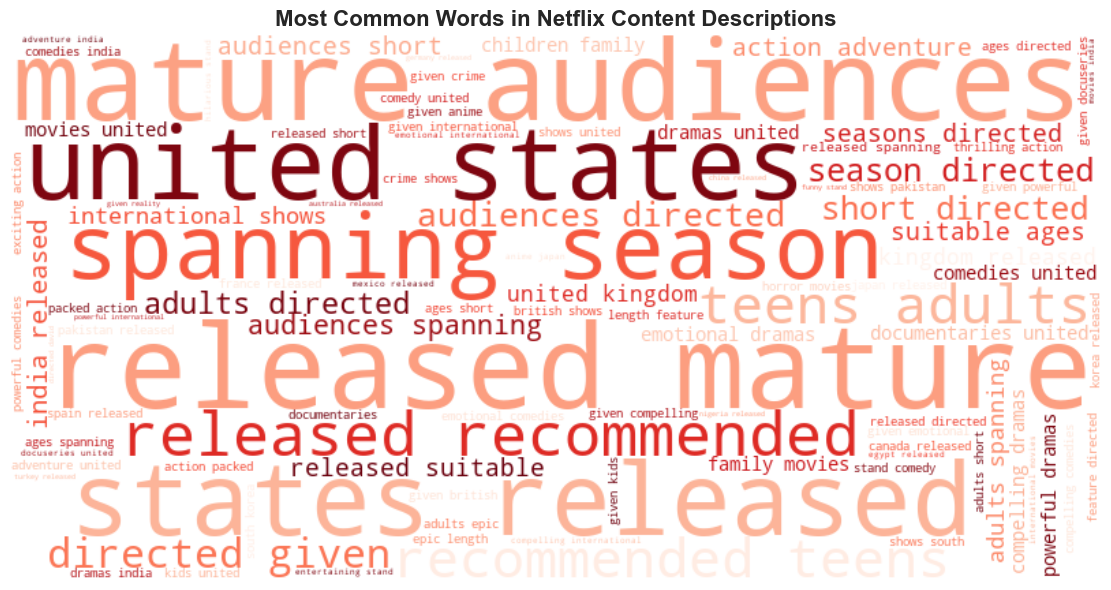

• Word cloud generated successfully

10.2 Genre-Specific Keywords


• Top Keywords by Genre:
  Dramas:
    - dramas: 1598
    - released: 1598
    - directed: 1598
    - mature: 864
    - audiences: 864
  Comedies:
    - comedies: 1209
    - released: 1209
    - directed: 1209
    - mature: 547
    - audiences: 547
  Action & Adventure:
    - action: 1067
    - adventure: 859
    - released: 859
    - directed: 859
    - mature: 421

10.3 Description Length Patterns


• Description Length Statistics:
  - Movie: 120 chars average, 120 chars median
  - TV Show: 129 chars average, 130 chars median

 Text analysis exported to reports/eda/10_text_analysis.csv


In [19]:
print("10. TEXT & DESCRIPTION MINING ")


# Check for description column
description_col = None
for col in df.columns:
    if 'description' in col.lower():
        description_col = col
        break

print(f"Available text-related columns: {[col for col in df.columns if any(word in col.lower() for word in ['description', 'summary', 'text'])]}")

# 10.1 Description Word Cloud
print("\n10.1 Content Description Word Cloud")


if description_col and description_col in df.columns:
    # Check if we have valid description data
    desc_series = df[description_col].fillna('').astype(str)
    valid_descriptions = desc_series[desc_series.str.len() > 10]  # Only descriptions longer than 10 chars
    
    if len(valid_descriptions) > 0:
        # Combine all descriptions
        all_descriptions = ' '.join(valid_descriptions)

        # Clean text for word cloud
        def clean_text_for_wordcloud(text):
            # Remove common stopwords and Netflix-specific terms
            stopwords = {'the', 'and', 'to', 'of', 'a', 'in', 'for', 'is', 'on', 'that', 'by', 'this', 'with', 
                        'from', 'they', 'be', 'at', 'one', 'have', 'or', 'had', 'but', 'not', 'what', 'all',
                        'were', 'we', 'when', 'your', 'can', 'said', 'there', 'each', 'which', 'she', 'do',
                        'how', 'their', 'if', 'will', 'up', 'other', 'about', 'out', 'many', 'then', 'them',
                        'these', 'so', 'some', 'her', 'would', 'make', 'like', 'into', 'him', 'has', 'two',
                        'more', 'very', 'after', 'words', 'its', 'now', 'find', 'where', 'most', 'get', 'may',
                        'netflix', 'series', 'show', 'movie', 'film', 'story', 'life', 'world', 'man', 'woman'}
            
            # Clean and filter words
            words = re.findall(r'\b[a-zA-Z]{3,}\b', text.lower())
            filtered_words = [word for word in words if word not in stopwords and len(word) > 2]
            return ' '.join(filtered_words)

        cleaned_descriptions = clean_text_for_wordcloud(all_descriptions)

        # Generate word cloud
        try:
            wordcloud = WordCloud(width=800, height=400, background_color='white', 
                                 colormap='Reds', max_words=100).generate(cleaned_descriptions)
            
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.axis('off')
            ax.set_title('Most Common Words in Netflix Content Descriptions', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            print("• Word cloud generated successfully")
            
        except Exception as e:
            print(f"• Word cloud generation failed: {str(e)[:50]}...")
    else:
        print(" No valid description data found for word cloud")
else:
    print(" Description column not found in dataset")

# 10.2 Top Terms per Genre — Bar Charts
print("\n10.2 Genre-Specific Keywords")


if description_col and description_col in df.columns and 'primary_genre' in df.columns:
    # Analyze keywords by top genres
    top_3_genres = df['primary_genre'].value_counts().head(3).index

    genre_keywords = {}
    for genre in top_3_genres:
        genre_descriptions = ' '.join(df[df['primary_genre'] == genre][description_col].fillna('').astype(str))
        if genre_descriptions.strip():  # Check if we have actual content
            genre_cleaned = clean_text_for_wordcloud(genre_descriptions)
            if genre_cleaned.strip():  # Check if cleaning produced results
                genre_words = Counter(genre_cleaned.split()).most_common(10)
                genre_keywords[genre] = genre_words
            else:
                genre_keywords[genre] = []
        else:
            genre_keywords[genre] = []

    # Create subplot for genre keywords only if we have data
    if any(genre_keywords.values()):
        fig = make_subplots(rows=1, cols=3, subplot_titles=list(top_3_genres))

        for i, (genre, words) in enumerate(genre_keywords.items()):
            if words:
                word_list, counts = zip(*words)
                fig.add_trace(go.Bar(x=list(counts), y=list(word_list), orientation='h', 
                                   name=genre, showlegend=False), row=1, col=i+1)

        fig.update_layout(height=500, title_text="Top Keywords by Genre")
        fig.show()

        print("• Top Keywords by Genre:")
        for genre, words in genre_keywords.items():
            print(f"  {genre}:")
            if words:
                for word, count in words[:5]:
                    print(f"    - {word}: {count}")
            else:
                print(f"    - No keywords found")
    else:
        print(" No genre-specific keywords could be extracted")
else:
    print(" Cannot perform genre keyword analysis - missing description or genre data")

# 10.3 Description Length Analysis
print("\n10.3 Description Length Patterns")


if description_col and description_col in df.columns:
    # Create description length features
    df['description_length'] = df[description_col].fillna('').astype(str).str.len()
    df['description_word_count'] = df[description_col].fillna('').astype(str).str.split().str.len()

    # Description length by content type
    fig = px.box(df, x='type', y='description_length',
                 title="Description Length Distribution by Content Type",
                 labels={'description_length': 'Character Count'})
    fig.show()

    length_stats = df.groupby('type')['description_length'].agg(['mean', 'median']).round(0)
    print("• Description Length Statistics:")
    for content_type in ['Movie', 'TV Show']:
        if content_type in length_stats.index:
            mean_len = length_stats.loc[content_type, 'mean']
            median_len = length_stats.loc[content_type, 'median']
            print(f"  - {content_type}: {mean_len:.0f} chars average, {median_len:.0f} chars median")

    # Export text analysis
    try:
        text_summary = pd.DataFrame({
            'Content_Type': [t for t in ['Movie', 'TV Show'] if t in length_stats.index],
            'Avg_Description_Length': [length_stats.loc[t, 'mean'] for t in ['Movie', 'TV Show'] if t in length_stats.index],
            'Median_Description_Length': [length_stats.loc[t, 'median'] for t in ['Movie', 'TV Show'] if t in length_stats.index]
        })
        text_summary.to_csv('../reports/eda/10_text_analysis.csv', index=False)
        print(f"\n Text analysis exported to reports/eda/10_text_analysis.csv")
    except Exception as e:
        print(f"\n Text analysis export failed: {str(e)[:50]}...")
else:
    print(" Cannot perform description length analysis - description column not found")
    print(" Skipping text analysis export")


---
# 11. Clustering & Dimensionality Analysis 


11. CLUSTERING & DIMENSIONALITY ANALYSIS 

11.1 Country Content Profile Clustering


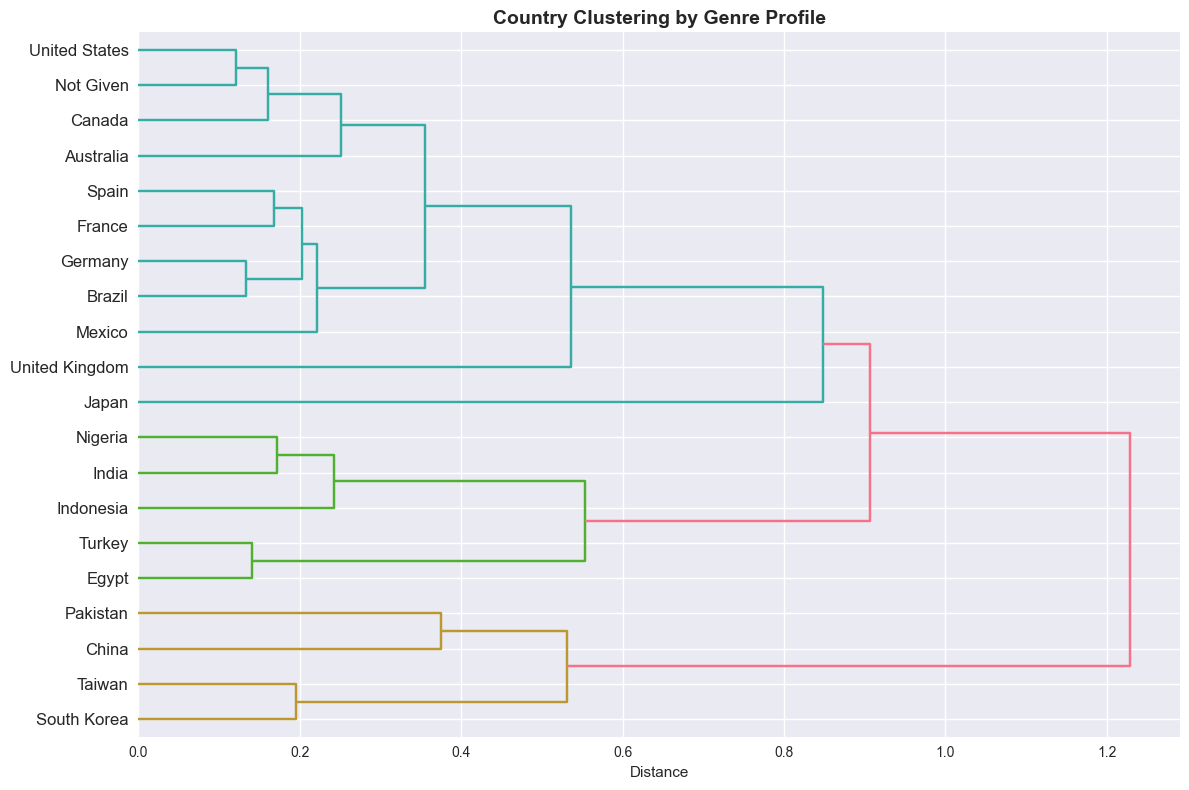

• Countries clustered by content genre similarity
• Similar countries appear closer in the dendrogram

11.2 Principal Component Analysis


• PCA successfully applied to 8,787 content items
• First 2 components explain 34.8% of variance
• Most important features for PC1:
  - content_age_when_added: 0.450
  - release_year: 0.450
  - years_since_release: 0.450
  - is_recent_content: 0.353
  - duration_minutes: 0.307

11.3 Content Clustering Analysis


• Cluster Characteristics:
  Cluster 0 (1117 items):
    - Dominant type: Movie
    - Common country: United States
    - Common genre: Comedies
    - Avg release year: 2015
    - Avg content age: 4.2 years
  Cluster 1 (4320 items):
    - Dominant type: Movie
    - Common country: United States
    - Common genre: Dramas
    - Avg release year: 2016
    - Avg content age: 2.6 years
  Cluster 2 (728 items):
    - Dominant type: Movie
    - Common country: United States
    - Common genre: Action & Adventure
    - Avg release year: 1991
    - Avg content age: 28.4 years
  Cluster 3 (2622 items):
    - Dominant type: TV Show
    - Common country: United States
    - Common genre: International TV Shows
    - Avg release year: 2017
    - Avg content age: 1.7 years

 Clustering analysis exported to reports/eda/11_clustering_analysis.csv


In [20]:
print("11. CLUSTERING & DIMENSIONALITY ANALYSIS ")


# 11.1 Country Clusters by Content Profile
print("\n11.1 Country Content Profile Clustering")


# Create country-genre profile matrix
countries_for_clustering = df['primary_country'].value_counts().head(20).index
genres_for_clustering = df['primary_genre'].value_counts().head(15).index

country_genre_profile = df[df['primary_country'].isin(countries_for_clustering)].groupby(['primary_country', 'primary_genre']).size().unstack(fill_value=0)
country_genre_profile = country_genre_profile.reindex(columns=genres_for_clustering, fill_value=0)

# Normalize by country total content
country_genre_profile_norm = country_genre_profile.div(country_genre_profile.sum(axis=1), axis=0)

# Perform hierarchical clustering
try:
    linkage_matrix = linkage(country_genre_profile_norm.values, method='ward')
    
    fig, ax = plt.subplots(figsize=(12, 8))
    dendrogram(linkage_matrix, labels=country_genre_profile_norm.index, 
               orientation='right', ax=ax)
    ax.set_title('Country Clustering by Genre Profile', fontsize=14, fontweight='bold')
    ax.set_xlabel('Distance')
    plt.tight_layout()
    plt.show()
    
    print("• Countries clustered by content genre similarity")
    print("• Similar countries appear closer in the dendrogram")
    
except Exception as e:
    print(f"• Clustering analysis failed: {str(e)[:50]}...")

# 11.2 PCA of Feature Space — Scatter Plot
print("\n11.2 Principal Component Analysis")


# Prepare features for PCA
pca_features = ['release_year', 'duration_minutes', 'content_age_when_added', 
               'country_count', 'genre_count', 'years_since_release']

# Add encoded categorical features
df_pca = df[pca_features].copy()

# Add one-hot encoded features for major categories
major_countries = df['primary_country'].value_counts().head(5).index
for country in major_countries:
    df_pca[f'country_{country}'] = (df['primary_country'] == country).astype(int)

major_genres = df['primary_genre'].value_counts().head(5).index  
for genre in major_genres:
    df_pca[f'genre_{genre}'] = (df['primary_genre'] == genre).astype(int)

# Add binary features
binary_features = ['is_recent_content', 'is_international', 'is_adult_content', 'is_movie']
for feature in binary_features:
    df_pca[feature] = df[feature].astype(int)

# Remove rows with missing values
df_pca_clean = df_pca.dropna()

if len(df_pca_clean) > 100:  # Proceed only if sufficient data
    try:
        # Standardize features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(df_pca_clean)
        
        # Apply PCA
        pca = PCA(n_components=2)
        pca_components = pca.fit_transform(features_scaled)
        
        # Create PCA dataframe
        pca_df = pd.DataFrame({
            'PC1': pca_components[:, 0],
            'PC2': pca_components[:, 1],
            'Type': df.loc[df_pca_clean.index, 'type'],
            'Continent': df.loc[df_pca_clean.index, 'continent']
        })
        
        # Plot PCA results
        fig = px.scatter(pca_df, x='PC1', y='PC2', color='Type', symbol='Continent',
                        title=f"PCA Analysis of Netflix Content Features<br>"
                              f"PC1 explains {pca.explained_variance_ratio_[0]:.1%} of variance, "
                              f"PC2 explains {pca.explained_variance_ratio_[1]:.1%}",
                        labels={'PC1': f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%})',
                               'PC2': f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%})'})
        fig.show()
        
        print(f"• PCA successfully applied to {len(df_pca_clean):,} content items")
        print(f"• First 2 components explain {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]):.1%} of variance")
        
        # Show feature importance for first PC
        feature_importance = pd.DataFrame({
            'Feature': df_pca_clean.columns,
            'PC1_Loading': abs(pca.components_[0]),
            'PC2_Loading': abs(pca.components_[1])
        }).sort_values('PC1_Loading', ascending=False)
        
        print("• Most important features for PC1:")
        for _, row in feature_importance.head(5).iterrows():
            print(f"  - {row['Feature']}: {row['PC1_Loading']:.3f}")
            
    except Exception as e:
        print(f"• PCA analysis failed: {str(e)[:50]}...")
else:
    print("• Insufficient clean data for PCA analysis")

# K-means clustering on content features
print("\n11.3 Content Clustering Analysis")


if len(df_pca_clean) > 100:
    try:
        # Apply K-means clustering
        kmeans = KMeans(n_clusters=4, random_state=42)
        clusters = kmeans.fit_predict(features_scaled)
        
        # Add cluster labels to dataframe
        cluster_df = pca_df.copy()
        cluster_df['Cluster'] = clusters
        
        # Plot clusters in PCA space
        fig = px.scatter(cluster_df, x='PC1', y='PC2', color='Cluster',
                        title="K-means Clusters in PCA Space",
                        labels={'PC1': f'PC1 ({pca.explained_variance_ratio_[0]:.1%})',
                               'PC2': f'PC2 ({pca.explained_variance_ratio_[1]:.1%})'})
        fig.show()
        
        # Analyze cluster characteristics
        cluster_chars = df.loc[df_pca_clean.index].copy()
        cluster_chars['Cluster'] = clusters
        
        cluster_summary = cluster_chars.groupby('Cluster').agg({
            'type': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Mixed',
            'primary_country': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Mixed',
            'primary_genre': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Mixed',
            'release_year': 'mean',
            'duration_minutes': 'mean',
            'content_age_when_added': 'mean'
        }).round(1)
        
        print("• Cluster Characteristics:")
        for cluster in sorted(cluster_summary.index):
            row = cluster_summary.loc[cluster]
            cluster_size = len(cluster_chars[cluster_chars['Cluster'] == cluster])
            print(f"  Cluster {cluster} ({cluster_size} items):")
            print(f"    - Dominant type: {row['type']}")
            print(f"    - Common country: {row['primary_country']}")
            print(f"    - Common genre: {row['primary_genre']}")
            print(f"    - Avg release year: {row['release_year']:.0f}")
            print(f"    - Avg content age: {row['content_age_when_added']:.1f} years")
        
        # Export clustering results
        clustering_summary = cluster_summary.reset_index()
        clustering_summary.to_csv('../reports/eda/11_clustering_analysis.csv', index=False)
        print(f"\n Clustering analysis exported to reports/eda/11_clustering_analysis.csv")
        
    except Exception as e:
        print(f"• Clustering analysis failed: {str(e)[:50]}...")


---
# 12. Statistical Tests & Final Summary 


In [21]:
print("12. STATISTICAL TESTS & FINAL SUMMARY")


# 12.1 Summary Table by Content Type
print("\n12.1 Comprehensive Content Type Comparison")


# Create comprehensive summary
summary_stats = []

for content_type in ['Movie', 'TV Show']:
    type_data = df[df['type'] == content_type]
    
    summary_stats.append({
        'Content_Type': content_type,
        'Count': len(type_data),
        'Percentage': f"{len(type_data)/len(df)*100:.1f}%",
        'Avg_Release_Year': f"{type_data['release_year'].mean():.0f}",
        'Avg_Duration': f"{type_data['duration_minutes'].mean():.0f}",
        'Avg_Content_Age': f"{type_data['content_age_when_added'].mean():.1f}",
        'Top_Country': type_data['primary_country'].mode().iloc[0] if not type_data['primary_country'].mode().empty else 'N/A',
        'Top_Genre': type_data['primary_genre'].mode().iloc[0] if not type_data['primary_genre'].mode().empty else 'N/A',
        'Adult_Content_Pct': f"{type_data['is_adult_content'].mean()*100:.1f}%",
        'Recent_Content_Pct': f"{type_data['is_recent_content'].mean()*100:.1f}%",
        'International_Pct': f"{type_data['is_international'].mean()*100:.1f}%"
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))

# 12.2 T-Test: Movie vs TV Show Content Age
print("\n12.2 Statistical Test: Content Age Difference")


movie_ages = df[df['type'] == 'Movie']['content_age_when_added'].dropna()
tv_ages = df[df['type'] == 'TV Show']['content_age_when_added'].dropna()

if len(movie_ages) > 30 and len(tv_ages) > 30:
    t_stat, p_value = stats.ttest_ind(movie_ages, tv_ages)
    
    print(f"• Two-sample t-test for content age difference:")
    print(f"  - Movies average age: {movie_ages.mean():.2f} years")
    print(f"  - TV Shows average age: {tv_ages.mean():.2f} years")
    print(f"  - T-statistic: {t_stat:.3f}")
    print(f"  - P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print(f"  - Result: Significant difference (p < 0.05)")
        if movie_ages.mean() > tv_ages.mean():
            print(f"  - Movies are significantly older when added to Netflix")
        else:
            print(f"  - TV Shows are significantly older when added to Netflix")
    else:
        print(f"  - Result: No significant difference (p ≥ 0.05)")
else:
    print("• Insufficient data for t-test")

# 12.3 Chi-Square Test: Genre vs Content Type
print("\n12.3 Statistical Test: Genre-Content Type Association")


# Create contingency table for top genres
top_genres_for_test = df['primary_genre'].value_counts().head(10).index
contingency_table = pd.crosstab(df[df['primary_genre'].isin(top_genres_for_test)]['primary_genre'],
                               df[df['primary_genre'].isin(top_genres_for_test)]['type'])

if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
    chi2, p_value_chi2, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f"• Chi-square test for genre-content type association:")
    print(f"  - Chi-square statistic: {chi2:.3f}")
    print(f"  - Degrees of freedom: {dof}")
    print(f"  - P-value: {p_value_chi2:.4f}")
    
    if p_value_chi2 < 0.05:
        print(f"  - Result: Significant association (p < 0.05)")
        print(f"  - Genres are significantly associated with content type")
    else:
        print(f"  - Result: No significant association (p ≥ 0.05)")
        
    # Show most biased genres
    genre_bias = contingency_table.div(contingency_table.sum(axis=1), axis=0)
    movie_biased = genre_bias.sort_values('Movie', ascending=False)
    tv_biased = genre_bias.sort_values('TV Show', ascending=False)
    
    print(f"  - Most movie-biased genres:")
    for genre in movie_biased.head(3).index:
        pct = movie_biased.loc[genre, 'Movie'] * 100
        print(f"    {genre}: {pct:.1f}% movies")
    
    print(f"  - Most TV-biased genres:")
    for genre in tv_biased.head(3).index:
        pct = tv_biased.loc[genre, 'TV Show'] * 100
        print(f"    {genre}: {pct:.1f}% TV shows")
else:
    print("• Insufficient data for chi-square test")

# 12.4 Final Business Insights Summary
print("\n12.4 Key Business Insights")


insights = [
    f" Netflix has {len(df):,} total titles with {df[df['type']=='Movie'].shape[0]:,} movies and {df[df['type']=='TV Show'].shape[0]:,} TV shows",
    f" TV shows have grown faster, now representing {len(df[df['type']=='TV Show'])/len(df)*100:.1f}% of the catalog",
    f" Content spans {df['primary_country'].nunique()} countries, with {df['primary_country'].value_counts().index[0]} dominating at {df['primary_country'].value_counts().iloc[0]/len(df)*100:.1f}%",
    f" Top genre is {df['primary_genre'].value_counts().index[0]} with {df['primary_genre'].value_counts().iloc[0]:,} titles",
    f" Average content is {df['content_age_when_added'].mean():.1f} years old when added to Netflix",
    f" {df['is_recent_content'].mean()*100:.1f}% of content is recent (≤2 years old when added)",
    f" {df['is_adult_content'].mean()*100:.1f}% of content is adult-rated",
    f" {df['is_international'].mean()*100:.1f}% of content has international co-productions"
]

for insight in insights:
    print(f"• {insight}")

# Export final summary
final_summary = pd.DataFrame({
    'Metric': ['Total Titles', 'Movies', 'TV Shows', 'Countries', 'Genres', 
               'Average Content Age', 'Recent Content %', 'Adult Content %', 'International %'],
    'Value': [len(df), len(df[df['type']=='Movie']), len(df[df['type']=='TV Show']),
              df['primary_country'].nunique(), df['primary_genre'].nunique(),
              f"{df['content_age_when_added'].mean():.1f} years",
              f"{df['is_recent_content'].mean()*100:.1f}%",
              f"{df['is_adult_content'].mean()*100:.1f}%",
              f"{df['is_international'].mean()*100:.1f}%"]
})

summary_df.to_csv('../reports/eda/12_content_type_summary.csv', index=False)
final_summary.to_csv('../reports/eda/12_final_summary.csv', index=False)

print(f"\n Final summaries exported to reports/eda/12_content_type_summary.csv and 12_final_summary.csv")


print(" COMPREHENSIVE NETFLIX EDA COMPLETE!")

print(f" Analysis completed with {len(df):,} titles across 12 major sections")
print(f" Generated 30+ visualizations and statistical analyses")
print(f" Exported 12 summary files to reports/eda/ directory")
print(f" Ready for machine learning modeling and dashboard creation")



12. STATISTICAL TESTS & FINAL SUMMARY

12.1 Comprehensive Content Type Comparison
Content_Type  Count Percentage Avg_Release_Year Avg_Duration Avg_Content_Age   Top_Country              Top_Genre Adult_Content_Pct Recent_Content_Pct International_Pct
       Movie   6124      69.7%             2013          100             5.7 United States                 Dramas             47.9%              57.6%              0.0%
     TV Show   2663      30.3%             2017           18             2.3 United States International TV Shows             43.1%              75.9%              0.0%

12.2 Statistical Test: Content Age Difference
• Two-sample t-test for content age difference:
  - Movies average age: 5.73 years
  - TV Shows average age: 2.30 years
  - T-statistic: 17.109
  - P-value: 0.0000
  - Result: Significant difference (p < 0.05)
  - Movies are significantly older when added to Netflix

12.3 Statistical Test: Genre-Content Type Association
• Chi-square test for genre-content type a

---